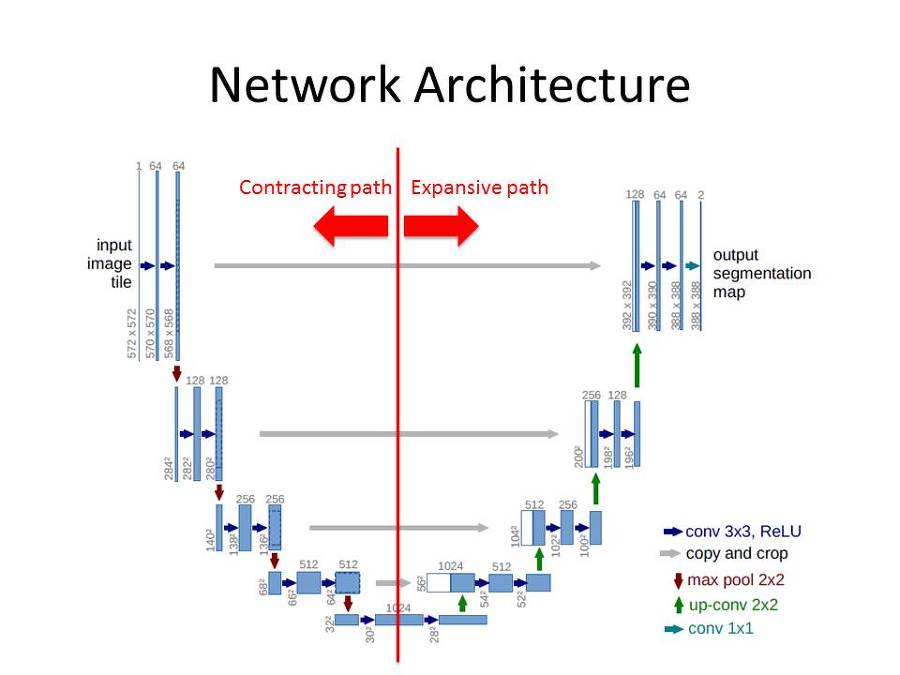

U-Nets are FCN(Fully Convolution Networks), which dont have anything but convolution layer. U-nets take input image and output some image. U-net used for Segmentation take input image and outputs segmentation mask, no labels needed. 

[Here's](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjDo7bH_prvAhXDzDgGHYJhDsAQFjAAegQIAxAD&url=https%3A%2F%2Fmedium.com%2Fswlh%2Fresnets-densenets-unets-6bbdbcfdf010&usg=AOvVaw36Ndu_QuQ4bZzzN2efV8A-) some more explaination on U-Nets architecture.

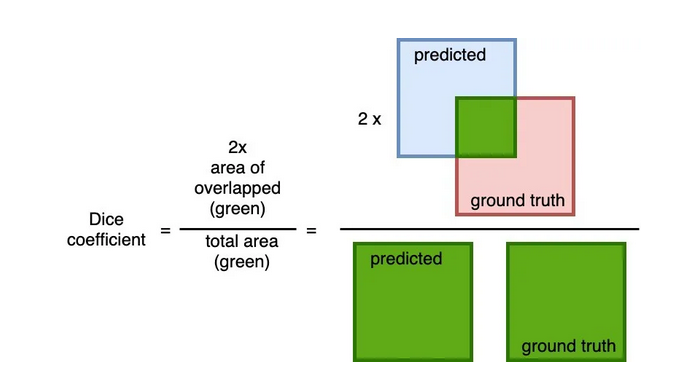

Loss function used is DICE loss(dice coefficient) which is essentially a measure of overlap between two samples. This measure ranges from 0 to 1 where a Dice coefficient of 1 denotes perfect and complete overlap.

In [2]:
import os, random, cv2, shutil
import numpy as np
import torch, torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
from collections import defaultdict
from torchvision import models
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (15,8)

seed = 2048
def seed_torch(seed=2021):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed)

In [ ]:
print(torch.cuda.get_device_name(0)) 

Tesla T4


## Download and show data

In [2]:
# copy dataset from drive

a = '/content/cleaned-oxford-pets-dataset.tar.gz'
b = '/content/drive/MyDrive/Datasets/cleaned-oxford-pets-dataset.tar.gz'

shutil.copyfile(b,a)

!tar -xzf /content/cleaned-oxford-pets-dataset.tar.gz
!rm -rf /content/content/cleaned-oxford-pets-dataset/images/Egyptian_Mau_129.jpg

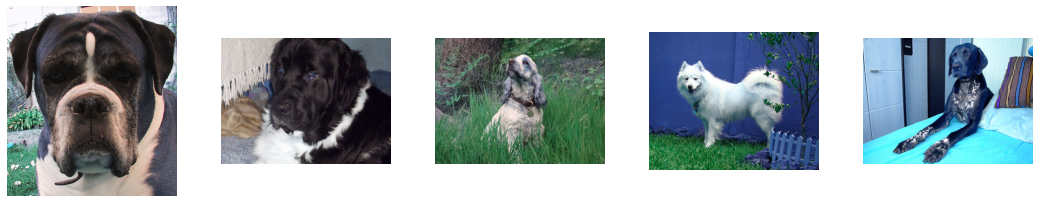

In [ ]:
image_ids = [a[:-4] for a in os.listdir("/content/content/cleaned-oxford-pets-dataset/images")[:5]]

r,c = 1,5
f, axs = plt.subplots(r,c)
f.tight_layout()
a= 0
p = '/content/content/cleaned-oxford-pets-dataset/images/'

for i in range(r):
  for j in range(c):
    im = cv2.imread(p+image_ids[a]+'.jpg')
    axs[j].imshow(im)
    axs[j].axis('off')
    a+=1

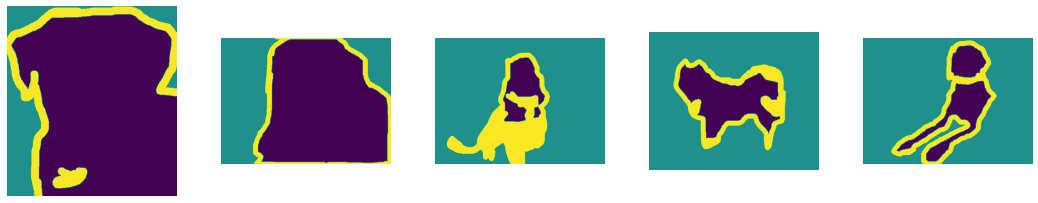

In [ ]:
# masks sample

r,c = 1,5
f, axs = plt.subplots(r,c)
f.tight_layout()
a= 0
p = '/content/content/cleaned-oxford-pets-dataset/trimaps/'

for i in range(r):
  for j in range(c):
    mask = cv2.imread(p+image_ids[a]+'.png', cv2.IMREAD_GRAYSCALE)
    axs[j].imshow(np.array(mask) / 2 * 255 )
    axs[j].axis('off')
    a+=1

# DataLoader

In [3]:
# create dataset

class PetsDataset(Dataset):

  def __init__(self, image_ids, transform=None):
    self.image_ids = image_ids # imgs are jpg, masks are png
    self.transform = transform
    self.image_size = [224,224]

  def __len__(self):
    return len(self.image_ids)

  def __getitem__(self, index):
    image_id = self.image_ids[index]
    image = cv2.imread("/content/content/cleaned-oxford-pets-dataset/images/" + image_id +'.jpg', cv2.COLOR_BGR2RGB)

    mask = cv2.imread("/content/content/cleaned-oxford-pets-dataset/trimaps/"+ image_id +'.png', cv2.IMREAD_UNCHANGED)
    mask = cv2.resize(mask, (self.image_size[0], self.image_size[1]), interpolation = cv2.INTER_NEAREST)

    # in this trimaps 1 "pet", 2 "background", 3 "border", so we make 1,3 = 1 and 2=0 (background)
    mask[mask == 2.0] = 0.0
    mask[(mask == 1.0) | (mask == 3.0)] = 1.0
    mask = torch.as_tensor(mask, dtype=torch.uint8)
    mask = mask.reshape(1, 224, 224)
    image = self.transform(image)

    return image, mask

In [4]:
batch_size = 64

image_ids = [a[:-4] for a in os.listdir("/content/content/cleaned-oxford-pets-dataset/images")]
x_train, x_val = train_test_split(image_ids, test_size=0.2, random_state=seed)

transform = transforms.Compose([
    transforms.ToTensor(),
    torchvision.transforms.Resize([224, 224]),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = PetsDataset(x_train, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = PetsDataset(x_val, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print('Train Dataset {} and Test Dataset {}'.format(len(train_dataset), len(val_dataset)))

Train Dataset 2803 and Test Dataset 701


In [ ]:
# test output
val_dataset[0][0].shape, val_dataset[0][1].shape

(torch.Size([3, 224, 224]), torch.Size([1, 224, 224]))

## Model

In [5]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [6]:
def dice_loss(prediction, target):
  """Calculating the dice loss
  Args:
      prediction = predicted image
      target = Targeted image
  Output:
      dice_loss"""
  smooth = 1.0
  i_flat = prediction.view(-1)
  t_flat = target.view(-1)
  intersection = (i_flat * t_flat).sum()
  return 1 - ((2. * intersection + smooth) / (i_flat.sum() + t_flat.sum() + smooth))

def calc_loss(prediction, target, bce_weight=0.5):
  """Calculating the loss and metrics
  Args:
      prediction = predicted image
      target = Targeted image
      metrics = Metrics printed
      bce_weight = 0.5 (default)
  Output:
      loss : dice loss of the epoch """    
  metrics = {}    
  bce = F.binary_cross_entropy_with_logits(prediction, target.type(torch.float))
  prediction = F.sigmoid(prediction)
  dice = dice_loss(prediction, target)

  loss = bce * bce_weight + dice * (1 - bce_weight)
  metrics['bce'] = bce.data.cpu().numpy() 
  metrics['dice'] = dice.data.cpu().numpy() 
  metrics['loss'] = loss.data.cpu().numpy()
  return loss, metrics

## Training

In [7]:
def train_one_epoch(model, train_loader):
    model.train()
    losses_dict = defaultdict(float) 
    for images, masks in train_loader:
      images = images.to('cuda')
      masks = masks.to('cuda')
      outputs = model(images)
      loss, metrics = calc_loss(outputs, masks)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      losses_dict['loss'] += metrics['loss']
      losses_dict['dice'] += metrics['dice']

    return losses_dict

def val_one_epoch(model, val_loader):
    model.eval()
    losses_dict = defaultdict(float) 
    for images, masks in val_loader:
      images = images.to('cuda')
      masks = masks.to('cuda')
      with torch.no_grad():
        outputs = model(images)
      loss, metrics = calc_loss(outputs, masks)
      losses_dict['loss'] += metrics['loss']
      losses_dict['dice'] += metrics['dice']

    return losses_dict

In [8]:
epochs = 10
lr = 0.002
MIN_LOSS = 0.0
train_step = len(train_dataset)/batch_size
val_step = len(val_dataset)/batch_size
TRAIN_LOSSES = []
VAL_LOSSES = []
model_save_path = '/content/pet_finder.bin'

model = ResNetUNet(n_class=1)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=8,gamma=0.1)
model = model.to('cuda')

for epoch in range(1, epochs+1):
  print('Epoch:',epoch)

  loss_dict = train_one_epoch(model, train_loader)
  train_l = loss_dict['loss'] / train_step
  train_dice_l = 1.0 - (loss_dict['dice'] / train_step)
  print("Training Loss:", train_l)
  print("Dice loss:",  train_dice_l)
  TRAIN_LOSSES.append(train_l)

  print('-'*10)
  loss_dict = val_one_epoch(model, val_loader)
  valid_l = loss_dict['loss'] / val_step
  valid_dice_l = 1.0 - (loss_dict['dice'] / val_step)
  print("Val Loss:", valid_l)
  print("Dice loss:", valid_dice_l)
  VAL_LOSSES.append(valid_l)

  if scheduler is not None:
    scheduler.step()

  if MIN_LOSS < valid_dice_l:
      MIN_LOSS = valid_dice_l
      torch.save({
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict()
                  }, model_save_path)
      print('Model Saved...')
  print('')   

Epoch: 1
Training Loss: 0.6251141415125465
Dice loss: 0.43888110957994575
----------
Val Loss: 0.6255261833419473
Dice loss: 0.4386625902118765
Model Saved...

Epoch: 2
Training Loss: 0.6231913204240748
Dice loss: 0.4452145685691983
----------
Val Loss: 0.6241345262731534
Dice loss: 0.44386846022667115
Model Saved...

Epoch: 3
Training Loss: 0.621418414352368
Dice loss: 0.4499280196702612
----------
Val Loss: 0.6221354779775404
Dice loss: 0.4483942094440977
Model Saved...

Epoch: 4
Training Loss: 0.6178590758885395
Dice loss: 0.45593153932798003
----------
Val Loss: 0.6166651313553183
Dice loss: 0.457315142926748
Model Saved...

Epoch: 5
Training Loss: 0.6058715387535571
Dice loss: 0.4743301549469876
----------
Val Loss: 0.5948958458131798
Dice loss: 0.4940590089806136
Model Saved...

Epoch: 6
Training Loss: 0.5647292217100853
Dice loss: 0.5302573063524119
----------
Val Loss: 0.5321695651545504
Dice loss: 0.5567307628680568
Model Saved...

Epoch: 7
Training Loss: 0.47502324039324495
D

Max Dice score is ~0.75

## Show Results

In [9]:
# model.load_state_dict(torch.load('/content/pet_finder.bin')['model_state_dict'])

model.eval()
images = []
predicted_masks = []
for im in x_val[:5]:
  image = cv2.imread("/content/content/cleaned-oxford-pets-dataset/images/" + im +'.jpg', cv2.COLOR_BGR2RGB)
  images.append(image)
  image = transform(image)
  image = image.to('cuda')
  with torch.no_grad():
    outputs = model(image.reshape(1, 3, 224, 224))
  predicted_masks.append(outputs.cpu().numpy().reshape(224, 224)) 

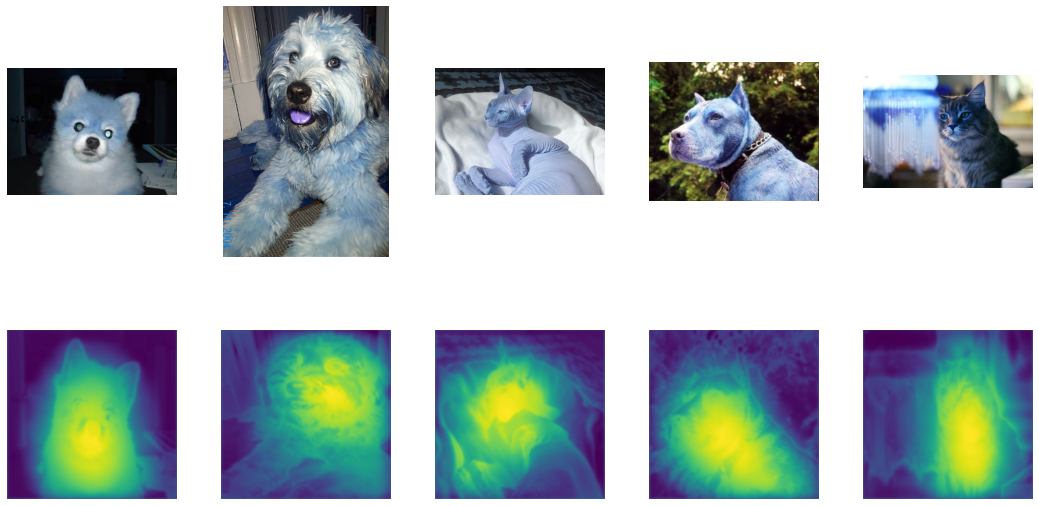

In [10]:
plt.rcParams["figure.figsize"] = (15,8)
r,c = 2,5
f, axs = plt.subplots(r,c)
f.tight_layout()
a= 0
imshows = images+predicted_masks

for i in range(r):
  for j in range(c):
    axs[i,j].imshow(imshows[a])
    axs[i,j].axis('off')
    a+=1

Summary: U-net tend to perform well on Semantic Segmentation task and are cheaper to train, imporvements:
* Data Augumentation.
* More Training.
* Tweak architecture.

Reference: 
https://github.com/bigmb/Unet-Segmentation-Pytorch-Nest-of-Unets